<a href="https://colab.research.google.com/github/usef-kh/SpeechRecognition/blob/master/Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To-Do
- Change models to TensorFlow
- Match notebook to sample submission

In [1]:
# Load Kaggle API Token
from google.colab import files
!pip install -q kaggle > /dev/null
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Load Data
!kaggle competitions download -c tensorflow-speech-recognition-challenge > /dev/null

# Unzip Data
!apt-get install p7zip-full > /dev/null
!p7zip -d train.7z > /dev/null


Saving kaggle.json to kaggle.json
100% 2.46G/2.46G [00:38<00:00, 67.7MB/s]
100% 1.04G/1.04G [00:26<00:00, 42.8MB/s]
100% 50.0/50.0 [00:00<00:00, 50.5kB/s]
100% 501k/501k [00:00<00:00, 69.6MB/s]


In [20]:
!p7zip -d sample_submission.7z 

/usr/bin/p7zip: cannot read sample_submission.7z


## Useful Imports and Functions

In [2]:
import librosa
import librosa.display
from scipy import signal
import numpy as np
from keras import backend as K
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import time
from IPython.display import Audio
from os import walk
from matplotlib import pyplot as plt

Using TensorFlow backend.


### Loading Data Helper funcitons

In [3]:
def generateFiles():
  train_audio_path = '/content/train/audio/'

  # Load all filenames into a dictionary so we can call on them easily
  files = {}
  for (dirpath, dirnames, filenames) in walk(train_audio_path):
    files[dirpath[21:]] = filenames

  files.pop('')
  files['_background_noise_'].remove('README.md')

  return files

In [6]:
def get_wav(file_name, nsamples=16000):
  wav = wavfile.read(file_name)[1]
  
  if wav.size < nsamples:
      audio = np.pad(wav, (nsamples - wav.size, 0), mode='constant')
  else:
      audio = wav[0:nsamples]
  return audio

def get_noise(filename, nsamples=16000, stepSize = 1000):
    wav = wavfile.read(filename)[1]

    noise = []
    for i in range((len(wav)-nsamples) // stepSize):
      start = i*stepSize
      subsample = wav[start: start + nsamples]
      
      if len(subsample) < nsamples:
          subsample = np.pad(wav, (nsamples - subsample.size, 0), mode='constant')
      noise.append(subsample)
    
    return noise

In [7]:
def loadData(files):
  train_audio_path = '/content/train/audio/'
  
  xtrain, ytrain = [], []
  for label, filenames in files.items():
    if label == '_background_noise_':
      for filename in filenames:
        noise = get_noise(train_audio_path + label + '/' + filename)
        xtrain.extend(noise)
        ytrain.extend(['silence']*len(noise))
    
    else:
      for filename in filenames:
        audio = get_wav(train_audio_path + label + '/' + filename)
        xtrain.append(audio)
        ytrain.append(label)
      
  return np.array(xtrain).astype(np.float32), np.array(ytrain)

### Preprocessing

In [8]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def calculateSpectograms(xtrain):
  spectograms = []
  rate = 16000
  for audio in xtrain:
    _, _, spectogram = log_specgram(audio, sample_rate=rate)
    spectograms.append(spectogram.T)

  return np.array(spectograms)

def calculateMFCCs(xtrain):
  MFCCs = []
  rate = 16000
  for audio in xtrain:
    mfcc = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc = 50, n_mels=128)
    MFCCs.append(mfcc.T)

  return np.array(MFCCs)

def normalize(x):
  minX = np.amin(x)
  maxX = np.amax(x)
  gap = maxX - minX

  return (x - (minX + 0.5*gap)) / (0.5 * gap)

def onehot(A, mapping=None):
  labels = set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown'])

  if mapping is None:
    mapping = {}
    maptolable = {}
    for i, label in enumerate(labels):
      temp = [0] * len(labels)
      temp[i] = 1
      mapping[label] = temp
      maptolable[i] = label
      
  res = []
  for label in A:
    if label in labels:
      res.append(mapping[label])
    else:
      res.append(mapping['unknown'])
  
  return np.array(res), mapping, maptolable

### Other Functions

In [9]:
def f1(y_true, y_pred):
  """Macro F1 Score

  A custom metric function that computes the average of the f1 scores 
  across all classesin a multiclass classificaiton problem
  """
  def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision * recall)/(precision + recall + K.epsilon()))

In [10]:
def swish(x, beta = 1):
    return (x * K.sigmoid(beta * x))

# Getting the Custom object and updating them 
from keras.utils.generic_utils import get_custom_objects 
from keras.layers import Activation 
  
# Below in place of swish you can take any custom key for the name  
get_custom_objects().update({'swish': Activation(swish)}) 

In [11]:
def performance_curves(history, metrics):
  def generate_plot(metric):
    train = history.history[metric]
    val = history.history['val_' + metric]
    x_axis = range(1, len(history.history[metric])+1)

    plt.figure()
    plt.plot(x_axis, train, label="Training " + metric)
    plt.plot(x_axis, val, label="Validation " + metric)

    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.title('Epochs vs ' + metric)
    plt.legend()
    plt.show()

    if metric == 'loss':
      print('Minimum Validation Loss is:', str(min(val)))
      print('Epoch: ', str(val.index(min(val)) + 1))
    else:
      print('Maximum', metric, 'is:', str(max(val)))
      print('Epoch: ', str(val.index(max(val)) + 1))
  
  for metric in ['loss'] + metrics:
    generate_plot(metric)

## LSTM vs. CNN (Raw Audio)

In [12]:
files = generateFiles()
X, Y = loadData(files)

debug = False
if debug:
  # Look at dataset size
  count = 0
  for label, samples in files.items():
    print(label, '\t', len(samples))
    count += len(samples)

  print("Number of Audio signals:", count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  # This is added back by InteractiveShellApp.init_path()


### LSTM

In [ ]:
Xfinal = X.reshape(-1, 16000, 1)
Yonehot, mapping, maptolable = onehot(Y)

xtrain, xval, ytrain, yval = train_test_split(Xfinal, Yonehot, test_size=0.2, random_state=127)

print('Number of Dimensions:', X.ndim)
print('Dataset')
print('\t', Xfinal.shape, '\t', Yonehot.shape)

print('\nTraining Data')
print('\t', xtrain.shape, '\t', ytrain.shape)

print('\nValidation Data')
print('\t', xval.shape, '\t', yval.shape)

Number of Dimensions: 2
Dataset
	 (71013, 16000, 1) 	 (71013, 12)

Training Data
	 (56810, 16000, 1) 	 (56810, 12)

Validation Data
	 (14203, 16000, 1) 	 (14203, 12)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten, Dropout, BatchNormalization, Conv1D, MaxPool1D

model = Sequential()

model.add(LSTM(32, input_shape = xtrain.shape[1:], activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# model.add(LSTM(64, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(len(mapping), activation = 'softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                780       
Total params: 7,372
Trainable params: 7,308
Non-trainable params: 64
___________________________________________________

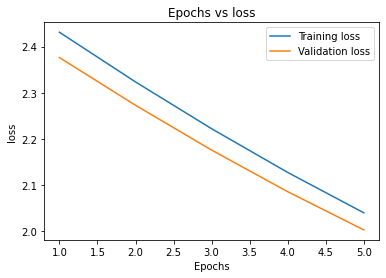

Minimum Validation Loss is: 2.0026544251834255
Epoch:  5


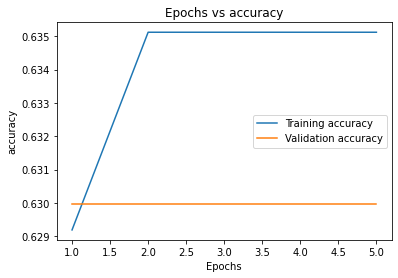

Maximum accuracy is: 0.6299729347229004
Epoch:  1


In [ ]:
history = model.fit(xtrain, ytrain, batch_size=512, validation_data=(xval, yval), epochs=5, shuffle=True, verbose=0)
performance_curves(history, ['accuracy'])

### CNN

In [13]:
Xfinal = X.reshape(-1, 16000, 1)

Yonehot, mapping, maptolable = onehot(Y)
Yonehot = Yonehot.reshape(-1, 1, 12)

xtrain, xval, ytrain, yval = train_test_split(Xfinal, Yonehot, test_size=0.2, random_state=127)

print('Number of Dimensions:', X.ndim)
print('Dataset')
print('\t', Xfinal.shape, '\t', Yonehot.shape)

print('\nTraining Data')
print('\t', xtrain.shape, '\t', ytrain.shape)

print('\nValidation Data')
print('\t', xval.shape, '\t', yval.shape)

Number of Dimensions: 2
Dataset
	 (71013, 16000, 1) 	 (71013, 1, 12)

Training Data
	 (56810, 16000, 1) 	 (56810, 1, 12)

Validation Data
	 (14203, 16000, 1) 	 (14203, 1, 12)


##Implementing CNN using Tensorflow

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, TimeDistributed, Conv1D, ZeroPadding1D, GRU, MaxPooling1D
from tensorflow.keras.layers import Lambda, Input, Dropout, Masking, BatchNormalization, Activation
from tensorflow.keras.models import Model

def CNN():
  input_shape = xtrain.shape[1:]
  # ---- Network model ----
  input_data = Input(name='the_input', shape=input_shape, dtype='float32')

  # 1 x 1D convolutional layers with strides 4
  x = Conv1D(filters=32, kernel_size=10, strides=4)(input_data)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.2)(x)

  x = Conv1D(filters=128, kernel_size=1, strides=1, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  x = Conv1D(filters=32, kernel_size=10, strides=4, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(3)(x)
  x = Dropout(0.2)(x)

  x = Conv1D(filters=128, kernel_size=1, strides=1, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  x = Conv1D(filters=64, kernel_size=10, strides=4, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.2)(x)

  x = Conv1D(filters=128, kernel_size=10, strides=4, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.2)(x)

  x = Dense(units=32, activation='relu')(x)
  x = Dropout(0.2)(x)

  # Output layer with softmax
  yPred = Dense(units = len(mapping), activation = 'softmax')(x)
  network_model = Model(inputs = input_data, outputs = yPred)

  return network_model

K.clear_session()
model = CNN()
model.summary()

RELU
444/444 [==============================] - 41s 93ms/step - loss: 1.4217 - f1: 0.5449 - accuracy: 0.6240 - val_loss: 1.0074 - val_f1: 0.6877 - val_accuracy: 0.6976


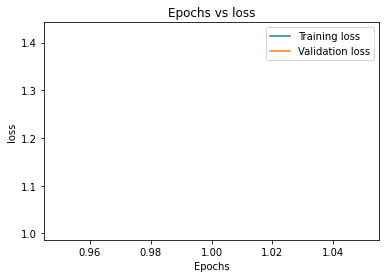

Minimum Validation Loss is: 1.0074061155319214
Epoch:  1


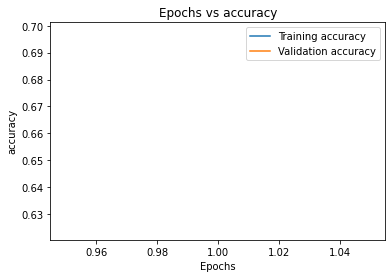

Maximum accuracy is: 0.6975991129875183
Epoch:  1


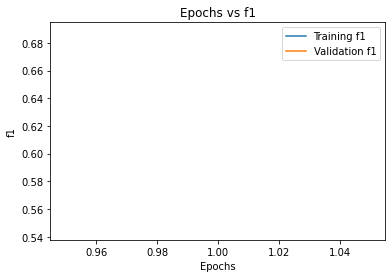

Maximum f1 is: 0.6876871585845947
Epoch:  1


In [18]:
# training model and plot results
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1, 'accuracy'])
print("RELU")
history2 = model.fit(xtrain, ytrain, batch_size=128, validation_data=(xval, yval), epochs=1, shuffle=True, verbose=1)
performance_curves(history2, ['accuracy', 'f1'])

In [ ]:
!p7zip -d test.7z > /dev/null


## Spectogram vs. MFCCs

In [ ]:
MFCCs = calculateMFCCs(X)
Spectograms = calculateSpectograms(X)

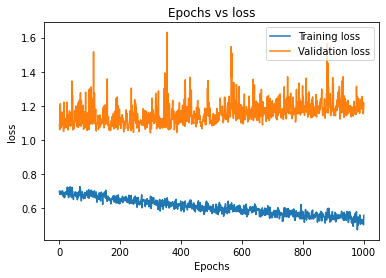

Minimum Validation Loss is: 1.041746973991394
Epoch:  300


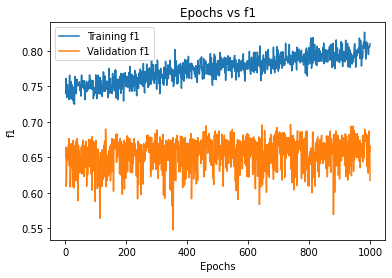

Maximum f1 is: 0.6962698698043823
Epoch:  739


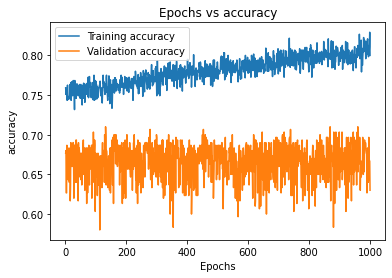

Maximum accuracy is: 0.7099999785423279
Epoch:  132


In [ ]:
# Using MFCCs
history = model.fit(xtrain, ytrain, batch_size=512, validation_data=(xval, yval), epochs=1000, shuffle=True, verbose=0)
performance_curves(history, ['f1', 'accuracy'])

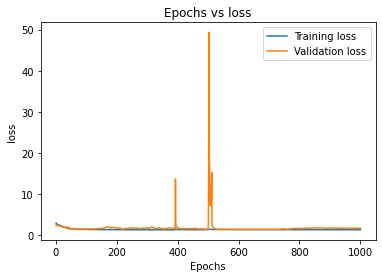

Minimum Validation Loss is: 1.4572668075561523
Epoch:  606


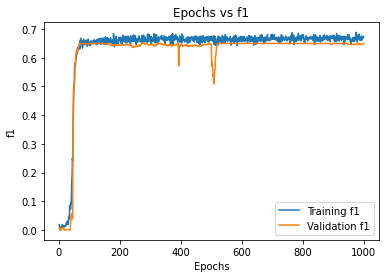

Maximum f1 is: 0.6521008014678955
Epoch:  278


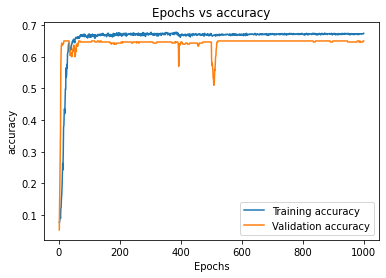

Maximum accuracy is: 0.6499999761581421
Epoch:  16


In [ ]:
# Using Spectograms
history = model.fit(xtrain, ytrain, batch_size=512, validation_data=(xval, yval), epochs=1000, shuffle=True, verbose=0)
performance_curves(history, ['f1', 'accuracy'])